# A General Equilibrium Model

# Setup

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import time
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from GEModel import GEModelClass

In [2]:
model = GEModelClass('baseline')
print(model)

Modelclass: GEModelClass

Parameters:
 r_ss = nan [float64]
 w_ss = nan [float64]
 Y_ss = nan [float64]
 C_ss = nan [float64]
 kd_ss = nan [float64]
 ks_ss = nan [float64]
 sigma = 1.0 [float64]
 beta = 0.982 [float64]
 Z = 1.0 [float64]
 alpha = 0.11 [float64]
 delta = 0.025 [float64]
 rho = 0.966 [float64]
 sigma_e = 0.5 [float64]
 Ne = 7 [int64]
 a_max = 200.0 [float64]
 Na = 500 [int64]
 tp_T = 500 [int64]
 max_iter_solve = 5000 [int64]
 max_iter_simulate = 5000 [int64]
 solve_tol = 1e-10 [float64]
 simulate_tol = 1e-10 [float64]
 a_grid = array(float64, 1d, C) with shape = (500,)
 e_grid = array(float64, 1d, C) with shape = (7,)
 e_trans = array(float64, 2d, C) with shape = (7, 7)
 e_ergodic = array(float64, 1d, C) with shape = (7,)
memory, gb: 0.0

Solution:
 a = array(float64, 2d, C) with shape = (7, 500)
 m = array(float64, 2d, C) with shape = (7, 500)
 c = array(float64, 2d, C) with shape = (7, 500)
 Va = array(float64, 2d, C) with shape = (7, 500)
 tp_a = array(float64, 3d, C

**Productivity states:**

In [3]:
par = model.par
for e,pr_e in zip(par.e_grid,par.e_ergodic):
    print(f'Pr[e = {e:.4f}] = {pr_e:.4f}')
    
assert np.isclose(np.sum(par.e_grid*par.e_ergodic),1.0)

Pr[e = 0.2595] = 0.0156
Pr[e = 0.3904] = 0.0938
Pr[e = 0.5872] = 0.2344
Pr[e = 0.8833] = 0.3125
Pr[e = 1.3286] = 0.2344
Pr[e = 1.9984] = 0.0937
Pr[e = 3.0060] = 0.0156


# Find Steady State

**Step 1:** Find demand and supply of capital for a grid of interest rates.

In [4]:
par = model.par

# a. interest rate trial values
Nr = 50
r_vec = np.linspace(0.0025,1.0/par.beta-1-0.0025,Nr) # 1+r > beta not possible

# b. allocate
Ks = np.zeros(Nr) 
Kd = np.zeros(Nr)

# c. loop
r_min = r_vec[0]
r_max = r_vec[Nr-1]
for i_r in range(Nr):
    
    # i. firm side
    k = model.firm_demand(r_vec[i_r])
    Kd[i_r] = k*1
    
    # ii. household side
    try:
        
        # solve and simulate
        model.solve_household_ss(r=r_vec[i_r])
        model.simulate_household_ss()
        
        # total demand
        Ks[i_r] = np.sum(model.sim.D*model.sol.a)
        
        # bounds on r
        diff = Ks[i_r]-Kd[i_r]
        if diff < 0: r_min = np.fmax(r_min,r_vec[i_r])
        if diff > 0: r_max = np.fmin(r_max,r_vec[i_r])
            
    except:
        
        Ks[i_r] = np.nan  
        

**Step 2:** Plot supply and demand.

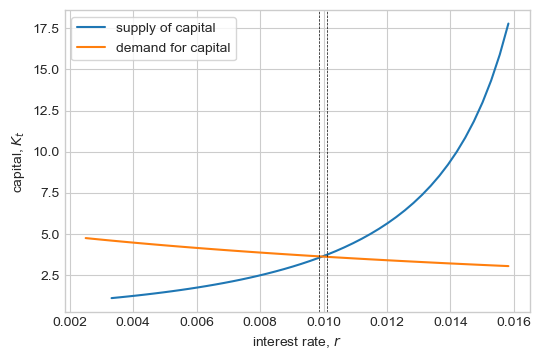

In [5]:
par = model.par

fig = plt.figure(figsize=(6,4),dpi=100)
ax = fig.add_subplot(1,1,1)

ax.plot(r_vec,Ks,label='supply of capital')
ax.plot(r_vec,Kd,label='demand for capital')

ax.axvline(r_min,lw=0.5,ls='--',color='black')
ax.axvline(r_max,lw=0.5,ls='--',color='black')

ax.legend(frameon=True)
ax.set_xlabel('interest rate, $r$')
ax.set_ylabel('capital, $K_t$');

**Step 3:** Solve root-finding problem.

In [6]:
def obj(r,model):
    
    model.solve_household_ss(r=r)
    model.simulate_household_ss()
    return np.sum(model.sim.D*model.sol.a)-model.firm_demand(r)

sol = optimize.root_scalar(obj,bracket=[r_min,r_max],method='bisect',args=(model,))
assert sol.converged

**Step 4:** Check market clearing conditions.

In [7]:
model.steady_state(sol.root)

household problem solved in 0.1 secs [554 iterations]
household problem simulated in 0.0 secs [708 iterations]

r: 0.0100
w: 1.0255
Y: 1.1522
K/Y: 3.1466

capital market clearing:  -0.00000000
goods market clearing:  -0.00000000


## Income uncertainty and the equilibrium interest rate

The equlibrium interest rate is increased towards $1/\beta-1$ when income uncertainty is removed.

In [8]:
par = model.par

# a. seetings
sigma_e_vec = [0.40,0.30,0.20]

# b. find equilibrium rates
r_max_ = 1.0/par.beta-1
model_ = model.copy()
for sigma_e in sigma_e_vec:
    
    # i. set new parameter
    model_.par.sigma_e = sigma_e
    
    # ii. find bracket
    r_max = model_.par.r_ss
    dr = (r_max_-r_max)/10
    while True:
        r_max += dr
        model_.solve_household_ss(r=r_max)
        model_.simulate_household_ss()
        diff = np.sum(model_.sim.D*model_.sol.a)-model_.firm_demand(r=r_max)
        if diff > 0:            
            break
                        
    # ii. solve
    print(f'sigma_e = {sigma_e:.4f} -> r_ss in [{r_max-dr:.4f},{r_max:.4f}]',end='')
    sol = optimize.root_scalar(obj,bracket=[r_max-dr,r_max],method='bisect',args=(model_,))
    print(f' -> {sol.root:.4f}')
    model_.steady_state(sol.root)    
    print('\n')

sigma_e = 0.4000 -> r_ss in [0.0116,0.0125] -> 0.0124
household problem solved in 0.1 secs [638 iterations]
household problem simulated in 0.0 secs [893 iterations]

r: 0.0124
w: 1.0170
Y: 1.1427
K/Y: 2.9424

capital market clearing:   0.00000000
goods market clearing:  -0.00000000


sigma_e = 0.3000 -> r_ss in [0.0142,0.0148] -> 0.0146
household problem solved in 0.2 secs [765 iterations]
household problem simulated in 0.1 secs [1237 iterations]

r: 0.0146
w: 1.0099
Y: 1.1347
K/Y: 2.7799

capital market clearing:   0.00000000
goods market clearing:  -0.00000001


sigma_e = 0.2000 -> r_ss in [0.0161,0.0164] -> 0.0164
household problem solved in 0.2 secs [937 iterations]
household problem simulated in 0.1 secs [2067 iterations]

r: 0.0164
w: 1.0042
Y: 1.1284
K/Y: 2.6568

capital market clearing:   0.00000000
goods market clearing:  -0.00000001




# Transition path

**MIT-shock:** Transtion path for arbitrary exogenous path of $Z_t$.

In [9]:
shock = 1.05
persistence = 0.9

In [10]:
tp_Z = np.ones(par.tp_T)
tp_Z[0] = shock*par.Z
for t in range(1,par.tp_T):
    tp_Z[t] = persistence*tp_Z[t-1] + (1-persistence)*par.Z

**Find transition path with relaxation algorithm:**

In [11]:
# a. allocate
tp_r = np.repeat(model.par.r_ss,par.tp_T) # use steady state as initial guess
tp_r_ = np.empty(par.tp_T)
tp_K = np.empty(par.tp_T)
tp_w = np.empty(par.tp_T)

# b. setting
nu = 0.90 # relaxation parameter
max_iter = 5000 # maximum number of iterations

# c. iterate
it = 0
tp_K[0] = np.sum(model.sim.D*model.sol.a) # capital is pre-determined
while True:
    
    # i. solve and simulate
    model.solve_household_tp(tp_r)
    model.simulate_household_tp()
    
    # ii. implied prices
    for t in range(par.tp_T):
        if t < par.tp_T-1: tp_K[t+1] = np.sum(model.sim.tp_D[t]*model.sol.tp_a[t])
        tp_r_[t] = model.implied_r(tp_K[t],tp_Z[t])
    
    # iii. difference
    max_abs_diff = np.max(np.abs(tp_r-tp_r_))
    if it%10 == 0: print(f'{it:4d}: {max_abs_diff:.8f}')
    if max_abs_diff < 1e-8: break
    
    # iv. update
    tp_r = nu*tp_r + (1-nu)*tp_r_
    
    # v.  increment
    it += 1
    if it > max_iter: raise Exception('too many iterations')    
    
# d. find wage    
for t in range(par.tp_T):
    tp_w[t] = model.implied_w(tp_r[t],tp_Z[t])

   0: 0.00174795
  10: 0.00060947
  20: 0.00021251
  30: 0.00007410
  40: 0.00002584
  50: 0.00000901
  60: 0.00000314
  70: 0.00000110
  80: 0.00000038
  90: 0.00000013
 100: 0.00000005
 110: 0.00000002


**Plot transition-paths:**

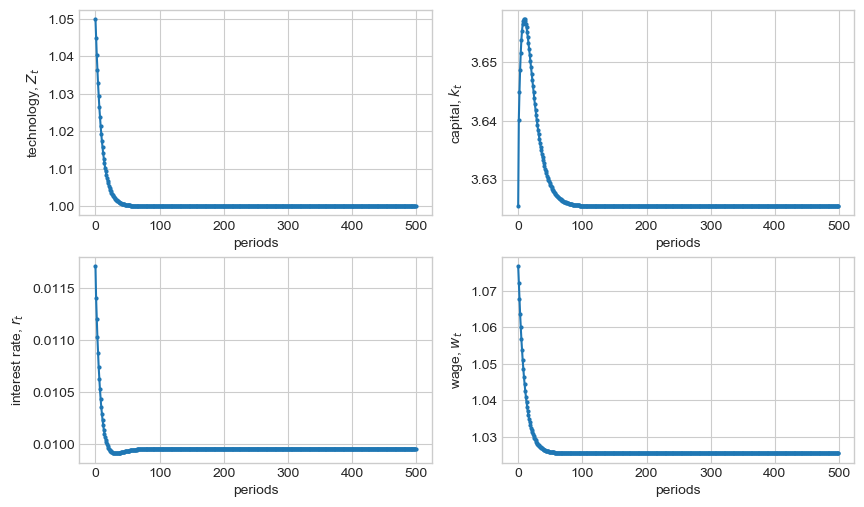

In [12]:
fig = plt.figure(figsize=(10,6),dpi=100)

ax = fig.add_subplot(2,2,1)
ax.plot(np.arange(par.tp_T),tp_Z,'-o',ms=2)
ax.set_xlabel('periods')
ax.set_ylabel('technology, $Z_t$');

ax = fig.add_subplot(2,2,2)
ax.plot(np.arange(par.tp_T),tp_K,'-o',ms=2)
ax.set_xlabel('periods')
ax.set_ylabel('capital, $k_t$');

ax = fig.add_subplot(2,2,3)
ax.plot(np.arange(par.tp_T),tp_r,'-o',ms=2)
ax.set_xlabel('periods')
ax.set_ylabel('interest rate, $r_t$');

ax = fig.add_subplot(2,2,4)
ax.plot(np.arange(par.tp_T),tp_w,'-o',ms=2)
ax.set_xlabel('periods')
ax.set_ylabel('wage, $w_t$');

# No income uncertainty

**Analytical solution for steady state:**

In [13]:
r_ss_pf = (1/par.beta-1) # from euler-equation
w_ss_pf = model.implied_w(r_ss_pf)
K_ss_pf = model.firm_demand(r_ss_pf)
Y_ss_pf = model.firm_production(K_ss_pf)
C_ss_pf = Y_ss_pf-par.delta*K_ss_pf

print(f'r: {r_ss_pf:.6f}')
print(f'w: {w_ss_pf:.6f}')
print(f'Y: {Y_ss_pf:.6f}')
print(f'C: {C_ss_pf:.6f}')
print(f'K/Y: {K_ss_pf/Y_ss_pf:.6f}')

r: 0.018330
w: 0.998613
Y: 1.122037
C: 1.050826
K/Y: 2.538660


**Function for finding consumption and capital paths given paths of interest rates and wages:**

It can be shown that

$$ C_{0}=\frac{(1+r_{0})a_{-1}+\sum_{t=0}^{\infty}\frac{1}{\mathcal{R}_{t}}w_{t}}{\sum_{t=0}^{\infty}\beta^{t/\rho}\mathcal{R}_{t}^{\frac{1-\rho}{\rho}}} $$

where 

$$ \mathcal{R}_{t} =\begin{cases} 1 & \text{if }t=0\\ (1+r_{t})\mathcal{R}_{t-1} & \text{else} \end{cases} $$

In [14]:
def tp_CK_func(K0,tp_r,tp_w,r_ss,w_ss,model):
    
    par = model.par
    
    # a. initialize
    wealth = (1+tp_r[0])*K0
    inv_MPC = 0
    
    # b. solve
    RT = 1
    max_iter = 5000
    t = 0
    while True and t < max_iter: 
        
        # i. prices padded with steady state
        r = tp_r[t] if t < par.tp_T else r_ss
        w = tp_w[t] if t < par.tp_T else w_ss
        
        # ii. interest rate factor 
        if t == 0:
            fac = 1
        else:
            fac *= (1+r)
        
        # iii. accumulate
        add_wealth = w/fac
        add_inv_MPC = par.beta**(t/par.sigma)*fac**((1-par.sigma)/par.sigma)
        if np.fmax(add_wealth,add_inv_MPC) < 1e-12:
            break
        else:
            wealth += add_wealth
            inv_MPC += add_inv_MPC
        
        # iv. increment
        t += 1
        
    # b. simulate
    tp_C = np.empty(par.tp_T)
    tp_K = np.empty(par.tp_T)
    
    for t in range(par.tp_T):
        
        if t == 0:
            tp_C[t] = wealth/inv_MPC
            K_lag = K0
        else:
            tp_C[t] = (par.beta*(1+tp_r[t]))**(1/par.sigma)*tp_C[t-1]
            K_lag = tp_K[t-1]
        
        tp_K[t] = (1+tp_r[t])*K_lag + tp_w[t] - tp_C[t]
            
    return tp_C,tp_K

Test with steady state prices:

In [15]:
tp_r_pf = np.repeat(r_ss_pf,par.tp_T)
tp_w_pf = np.repeat(w_ss_pf,par.tp_T)
tp_C_pf,tp_K_pf = tp_CK_func(K_ss_pf,tp_r_pf,tp_w_pf,r_ss_pf,w_ss_pf,model)

In [16]:
print(f'C_ss:  {C_ss_pf:.6f}')
print(f'C[0]:  {tp_C_pf[0]:.6f}')
print(f'C[-1]: {tp_C_pf[-1]:.6f}')
assert np.isclose(C_ss_pf,tp_C_pf[0])

C_ss:  1.050826
C[0]:  1.050826
C[-1]: 1.050826


**Shock paths** where interest rate deviate in one period:

In [17]:
Delta = 1e-4
ts = np.array([0,20,40])
tp_C_pf_shock = np.empty((ts.size,par.tp_T))
tp_K_pf_shock = np.empty((ts.size,par.tp_T))

for i,t in enumerate(ts):
    tp_r_pf_shock = tp_r_pf.copy()
    tp_r_pf_shock[t] += Delta 
    A,B = tp_CK_func(K_ss_pf,tp_r_pf_shock,tp_w_pf,r_ss_pf,w_ss_pf,model)
    tp_C_pf_shock[i,:] = A
    tp_K_pf_shock[i,:] = B

Plot paths:

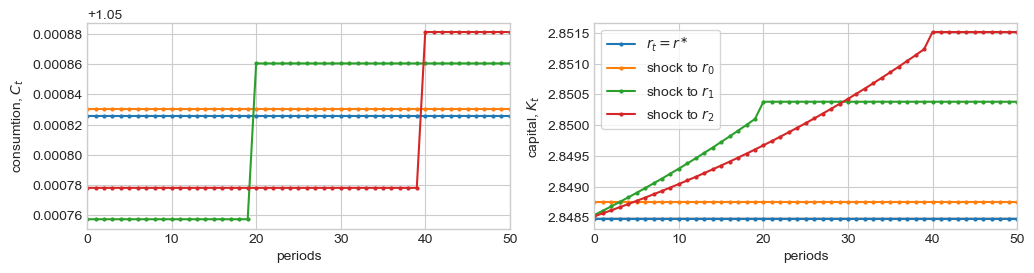

In [18]:
fig = plt.figure(figsize=(12,6),dpi=100)

ax = fig.add_subplot(2,2,1)
ax.plot(np.arange(par.tp_T),tp_C_pf,'-o',ms=2,label=f'$r_t = r^{{\\ast}}$')
for i,t in enumerate(range(ts.size)):
    ax.plot(np.arange(par.tp_T),tp_C_pf_shock[i],'-o',ms=2,label=f'shock to $r_{{{t}}}$')
    
ax.set_xlim([0,50])
ax.set_xlabel('periods')
ax.set_ylabel('consumtion, $C_t$');

ax = fig.add_subplot(2,2,2)
ax.plot(np.arange(par.tp_T),tp_K_pf,'-o',ms=2,label=f'$r_t = r^{{\\ast}}$')
for i,t in enumerate(range(ts.size)):
    ax.plot(np.arange(par.tp_T),tp_K_pf_shock[i],'-o',ms=2,label=f'shock to $r_{{{t}}}$')
    
ax.legend(frameon=True)
ax.set_xlim([0,50])
ax.set_xlabel('periods')
ax.set_ylabel('capital, $K_t$');


**Find transition path with shooting algorithm:**

In [19]:
# a. allocate
dT = 200
tp_C_pf = np.empty(par.tp_T)
tp_K_pf = np.empty(par.tp_T)
tp_r_pf = np.empty(par.tp_T)
tp_w_pf = np.empty(par.tp_T)

# b. settings
C_min = C_ss_pf
C_max = C_ss_pf + K_ss_pf

K_min = 1.5 # guess on lower consumption if below this
K_max = 3 # guess on higher consumption if above this

tol_pf = 1e-6
max_iter_pf = 5000

tp_K_pf[0] = K_ss_pf # capital is pre-determined

# c. iterate
t = 0
it = 0
while True:

    # i. update prices
    tp_r_pf[t] = model.implied_r(tp_K_pf[t],tp_Z[t])
    tp_w_pf[t] = model.implied_w(tp_r_pf[t],tp_Z[t])
    
    # ii. consumption     
    if t == 0:
        C0 = (C_min+C_max)/2
        tp_C_pf[t] = C0
    else:
        tp_C_pf[t] = (1+tp_r_pf[t])*par.beta*tp_C_pf[t-1]
    
    # iii. check for steady state
    if tp_K_pf[t] < K_min:
        t = 0
        C_max = C0
        continue
    elif tp_K_pf[t] > K_max:
        t = 0
        C_min = C0
        continue
    elif t > 10 and np.sqrt((tp_C_pf[t]-C_ss_pf)**2+(tp_K_pf[t]-K_ss_pf)**2) < tol_pf:
        tp_C_pf[t:] = tp_C_pf[t]
        tp_K_pf[t:] = tp_K_pf[t]
        for k in range(par.tp_T):
            tp_r_pf[k] = model.implied_r(tp_K_pf[k],tp_Z[k])
            tp_w_pf[k] = model.implied_w(tp_r_pf[k],tp_Z[k])
        break
        
    # iv. update capital
    tp_K_pf[t+1] = (1+tp_r_pf[t])*tp_K_pf[t] + tp_w_pf[t] - tp_C_pf[t]    
    
    # v. increment
    t += 1
    it += 1
    if it > max_iter: break    

**Plot deviations from steady state:**

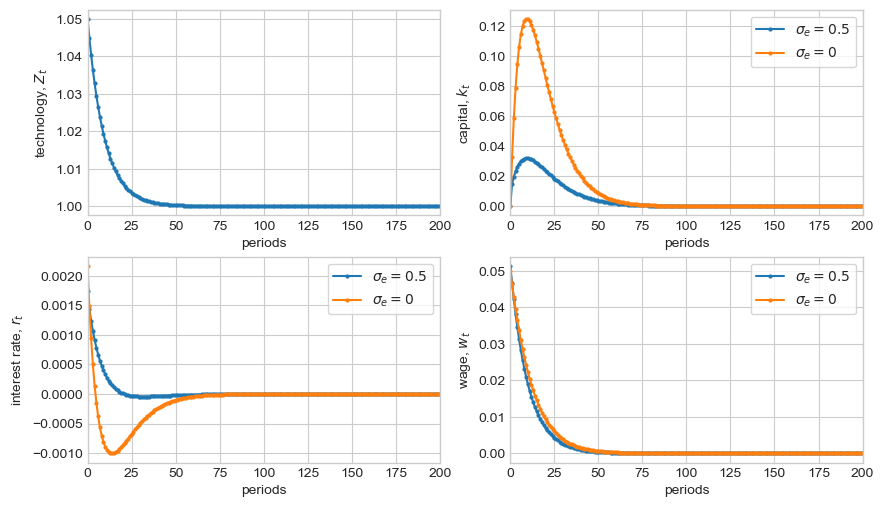

In [20]:
fig = plt.figure(figsize=(10,6),dpi=100)

ax = fig.add_subplot(2,2,1)
ax.plot(np.arange(par.tp_T),tp_Z,'-o',ms=2)
ax.set_xlim([0,200])
ax.set_xlabel('periods')
ax.set_ylabel('technology, $Z_t$');

ax = fig.add_subplot(2,2,2)
ax.plot(np.arange(par.tp_T),tp_K-model.par.kd_ss,'-o',ms=2,label='$\sigma_e = 0.5$')
ax.plot(np.arange(par.tp_T),tp_K_pf-K_ss_pf,'-o',ms=2,label='$\sigma_e = 0$')
ax.legend(frameon=True)
ax.set_xlim([0,200])
ax.set_xlabel('periods')
ax.set_ylabel('capital, $k_t$');

ax = fig.add_subplot(2,2,3)
ax.plot(np.arange(par.tp_T),tp_r-model.par.r_ss,'-o',ms=2,label='$\sigma_e = 0.5$')
ax.plot(np.arange(par.tp_T),tp_r_pf-r_ss_pf,'-o',ms=2,label='$\sigma_e = 0$')
ax.legend(frameon=True)
ax.set_xlim([0,200])
ax.set_xlabel('periods')
ax.set_ylabel('interest rate, $r_t$');

ax = fig.add_subplot(2,2,4)
ax.plot(np.arange(par.tp_T),tp_w-model.par.w_ss,'-o',ms=2,label='$\sigma_e = 0.5$')
ax.plot(np.arange(par.tp_T),tp_w_pf-w_ss_pf,'-o',ms=2,label='$\sigma_e = 0$')
ax.legend(frameon=True)
ax.set_xlabel('periods')
ax.set_xlim([0,200])
ax.set_ylabel('wage, $w_t$');